In [2]:
import json
from collections import defaultdict
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re

/home/cmu/miniconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenizer = AutoTokenizer.from_pretrained("d1shs0ap/cognitive-behaviors-Llama-3.2-3B")

In [4]:
step_to_rollouts = {}

for step in range(0, 72 + 1, 24):
    rollouts_file = f"/home/cmu/countdown-curriculum/checkpoints/train-5-5-normal-2048/{step}_rollouts.json"
    with open(rollouts_file, 'r') as f:
        step_to_rollouts[step] = json.load(f)


step_to_positive_rollouts = {}

for step in range(0, 72 + 1, 24):
    rollouts_file = f"/home/cmu/countdown-curriculum/checkpoints/train-5-5-positive-2048/{step}_rollouts.json"
    with open(rollouts_file, 'r') as f:
        step_to_positive_rollouts[step] = json.load(f)

In [18]:
def get_id_to_correct_length(rollouts, is_correct = True, attempts = False):
    id_to_correct_length = {}
    for i in range(len(rollouts) // 8):
        if rollouts[i * 8]['ref_score'] != 5:
            continue
        
        avg_correct_length = 0
        total = 0
        for j in range(8):
            if rollouts[i * 8 + j]['score'] == is_correct:
                if attempts:
                    avg_correct_length += len(set(rollouts[i * 8 + j]['output'].split('\n\n')))
                else:
                    avg_correct_length += rollouts[i * 8 + j]['length']
                total += 1
        
        if avg_correct_length > 0:
            id_to_correct_length[i] = avg_correct_length / total

    return id_to_correct_length

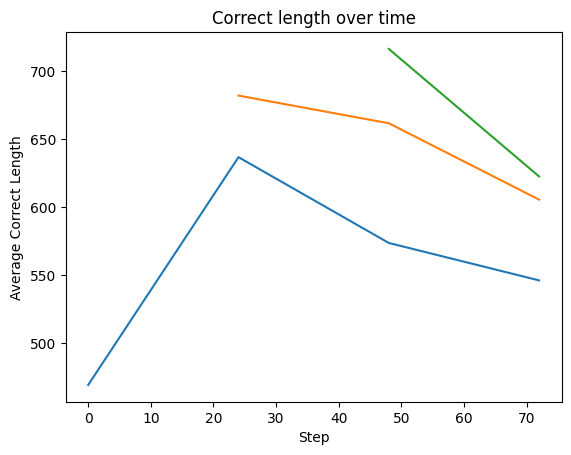

In [9]:
for step in range(0, 72 + 1, 24):
    base_rollouts = step_to_rollouts[step]
    
    base_id_to_correct_length = get_id_to_correct_length(base_rollouts)
    correct_lengths = []

    for next_step in range(step, 72 + 1, 24):
        rollouts = step_to_rollouts[next_step]
        
        next_id_to_correct_length = get_id_to_correct_length(rollouts)

        avg_correct_length = 0
        intersection_keys = base_id_to_correct_length.keys() & next_id_to_correct_length.keys()
        for id in intersection_keys:
            avg_correct_length += next_id_to_correct_length[id]
        
        correct_lengths.append(avg_correct_length / len(intersection_keys))
    
    plt.plot(range(step, 72 + 1, 24), correct_lengths, label="Correct Length")

plt.title("Correct length over time")
plt.xlabel("Step")
plt.ylabel("Average Correct Length")
plt.show()


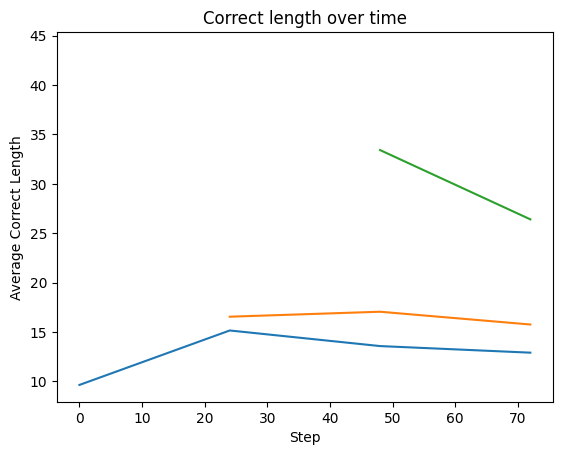

In [20]:
seen = set()

for step in range(0, 72 + 1, 24):
    base_rollouts = step_to_rollouts[step]
    
    base_id_to_correct_length = get_id_to_correct_length(base_rollouts, attempts=True)
    base_positive_id_to_incorrect_length = get_id_to_correct_length(base_rollouts, False, attempts=True)
    correct_lengths = []
    

    for next_step in range(step, 72 + 1, 24):
        rollouts = step_to_rollouts[next_step]
        
        next_id_to_correct_length = get_id_to_correct_length(rollouts, attempts=True)

        avg_correct_length, total = 0, 0
        intersection_keys = base_id_to_correct_length.keys() & next_id_to_correct_length.keys()
        for id in intersection_keys:
            if id in seen:
                continue
            avg_correct_length += next_id_to_correct_length[id]
            total += 1
        
        correct_lengths.append(avg_correct_length / total)
    
    seen.update(base_id_to_correct_length.keys())
    plt.plot(range(step, 72 + 1, 24), correct_lengths, label="Correct Length")

plt.title("Correct length over time")
plt.xlabel("Step")
plt.ylabel("Average Correct Length")
plt.show()


In [57]:

last_positive_rollouts = step_to_positive_rollouts[72]
positive_unsolved = set()

for i in range(len(last_positive_rollouts) // 8):
    if last_positive_rollouts[i * 8]['ref_score'] != 5:
        continue
    
    unsolved = True
    for step in range(0, 72 + 1, 24):
        rollouts = step_to_positive_rollouts[step]
        
        for j in range(8):
            if rollouts[i * 8 + j]['score'] == 1:
                unsolved = False
                break
    
    if unsolved:
        positive_unsolved.add(i)

323
365
355
323
409
394


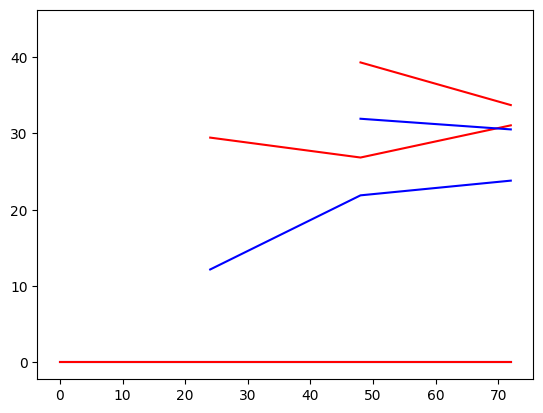

In [61]:
seen = set()

for step in range(0, 72 + 1, 24):
    base_rollouts = step_to_rollouts[step]
    base_id_to_correct_length = get_id_to_correct_length(base_rollouts, attempts=True)

    new_corrects = set()
    for key in positive_unsolved:
        if key in base_id_to_correct_length and key not in seen:
            new_corrects.add(key)

    correct_lengths = []
    incorrect_lengths = []
    
    for next_step in range(step, 72 + 1, 24):
        rollouts = step_to_rollouts[next_step]
        
        next_id_to_correct_length = get_id_to_correct_length(rollouts, attempts=True)

        avg_correct_length, total = 0, 0
        for id in new_corrects:
            if id not in next_id_to_correct_length:
                print(id)
                continue
            avg_correct_length += next_id_to_correct_length[id]
            total += 1
        
        if total > 0:
            correct_lengths.append(avg_correct_length / total)
        else:
            correct_lengths.append(0)

        incorrect_rollouts = step_to_positive_rollouts[next_step]
        next_id_to_positive_incorrect_length = get_id_to_correct_length(incorrect_rollouts, False, attempts=True)
        avg_incorrect_length, total = 0, 0
        for id in new_corrects:
            avg_incorrect_length += next_id_to_positive_incorrect_length[id]
            total += 1
        if total > 0:
            incorrect_lengths.append(avg_incorrect_length / total)
        else:
            incorrect_lengths.append(0)
    
    seen.update(base_id_to_correct_length.keys())
    plt.plot(range(step, 72 + 1, 24), correct_lengths, label="Correct Length", color='blue')
    plt.plot(range(step, 72 + 1, 24), incorrect_lengths, label="Incorrect Length", color='red')

# plt.title("Correct length over time")
# plt.xlabel("Step")
# plt.ylabel("Average Correct Length")
# plt.show()

In [50]:
for step in range(0, 72 + 1, 24):
    rollouts = step_to_rollouts[step]
    print(rollouts[444 * 8 + 6]['length'])

543
2049
2049
1818
